## gap size redistribution
    - generate x in linspace  region [lower_lim, upper_lim]
    - compute corresponding y values
    - repeat until y are evenly spaced:
        - find largest gap
        - find smallest gap
        - replace one member of smallest gap pair with a point in the centre of the largest gap
    - find non-dominated y

In [1]:
%pylab
%matplotlib inline
import wfg

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
## define helper functions
def notDominated(X):
    """
    Return a Boolean vector with as many rows as X indicating whether each
    row of X is not dominated by the other elements of X; ie, whether each
    row is Pareto optimal for X.
    """
    y = zeros(X.shape[0], dtype='bool')
    for n in range(X.shape[0]):
        # Find the number of times on each row where X[i,j] >= X[n,j];
        # y[n] is not dominated if this is bigger than for every row
        y[n] = min(sum(X >= X[n,:], 1)) > 0
    return y

In [3]:
## wfg problem
M = 2                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(M-1)
l = lfactor*2

func = wfg.WFG2

x_limits = np.array([[0]*(k+l),[i*2 for i in range(1, k+l+1)]])
x_limits

array([[ 0,  0,  0,  0,  0,  0],
       [ 2,  4,  6,  8, 10, 12]])

In [4]:
## linearly space samples in parameter space
n_samples = 2000
samples0 = np.linspace(0, x_limits[1][0], n_samples)
samples1 = np.linspace(0, x_limits[1][1], n_samples)
x_orig = np.array([[sample0, sample1, 2.1, 2.8, 3.5, 4.2] for sample0, sample1 in zip(samples0, samples1)])

assert x_orig.shape == (n_samples, k+l)
x_orig.max(axis=0)

array([2. , 4. , 2.1, 2.8, 3.5, 4.2])

In [5]:
## get corresponding y values
y_orig = np.zeros((n_samples, M))
for i, xi in enumerate(x_orig):
    y_orig[i,:] = func(xi, k, M)
    
assert y_orig.shape == (n_samples, M)
y_orig.shape

(2000, 2)

In [6]:
## get indices for non-dominated elements of original samples
pi_orig = notDominated(y_orig) 
di_orig = np.invert(pi_orig)

In [7]:
## compute euclidean point distances
diffs_orig = y_orig[:-1] - y_orig[1:]
gaps_orig = np.array([np.sqrt(np.dot(d, d.T)) for d in diffs_orig])

np.testing.assert_array_equal(y_orig[np.argsort(y_orig[:,0])], y_orig)
gaps_orig.shape

(1999,)

Text(0.5, 1.0, 'inter-sample gap sizes')

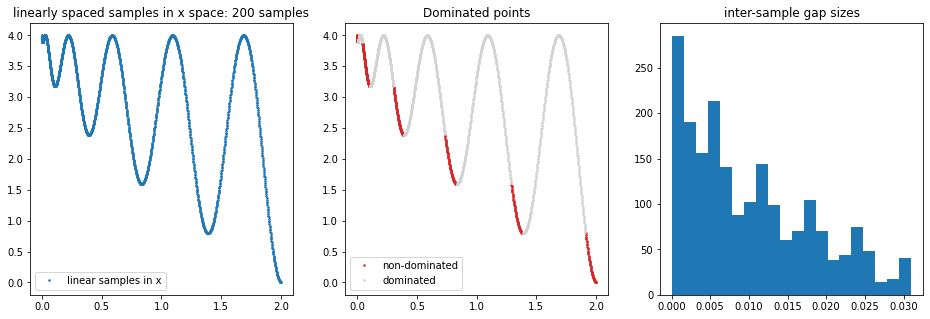

In [8]:
fig = plt.figure(figsize=[16, 5])
ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)
ax0.plot(*y_orig.T, '.',  ms="3", label="linear samples in x")
ax0.legend()

ax1.plot(*y_orig[pi_orig].T, '.',  ms="3", c="C3", label="non-dominated")
ax1.plot(*y_orig[di_orig].T, '.',  ms="3", c="lightgrey", label="dominated")
ax1.legend()

flls, bins, _ = ax2.hist(gaps_orig, bins=20)

ax0.set_title("linearly spaced samples in x space: 200 samples")
ax1.set_title("Dominated points")
ax2.set_title("inter-sample gap sizes")

In [9]:
x = x_orig.copy()
y = y_orig.copy()

for i in range(5000):
    sorted_y = y[np.argsort(y[:,0])]
    sorted_x = x[np.argsort(y[:,0])]
    diffs = sorted_y[:-1]-sorted_y[1:]
    gaps = np.array([np.sqrt(np.dot(d, d.T)) for d in diffs])
    
    gap_min_i = np.argmin(gaps)
    gap_min_j = gap_min_i+1
    gap_max_i = np.argmax(gaps)
    gap_max_j = gap_max_i+1
    
    # point to remove
    ## TODO: modify this to chose from [gap_min_i, gap_min_j] appropriately
    remove_point = gap_min_i
    
    # point to add
    x_new = (sorted_x[gap_max_i]+sorted_x[gap_max_j])/2
    y_new = func(x_new, k, M)
    
    # swap new point for remove point
    swap_ind =np.where([np.all(xi == sorted_x[remove_point]) for xi in x])[0][0]
    x[swap_ind] = x_new
    y[swap_ind] = y_new

x_final = x.copy()
y_final = y.copy()

assert x_final.shape == x_orig.shape
assert y_final.shape == y_orig.shape

y_final = y_final[np.argsort(y_final[:,0])][::10]

In [10]:
y_final.shape

(200, 2)

In [11]:
## get indices for non-dominated elements of resulting samples
pi_final = notDominated(y_final) 
di_final = np.invert(pi_final)

In [12]:
## compute euclidean point distances
diffs_final = y_final[:-1] - y_final[1:]
gaps_final = np.array([np.sqrt(np.dot(d, d.T)) for d in diffs_final])
gaps_final.shape

(199,)

Text(0.5, 1.0, 'inter-sample gap sizes')

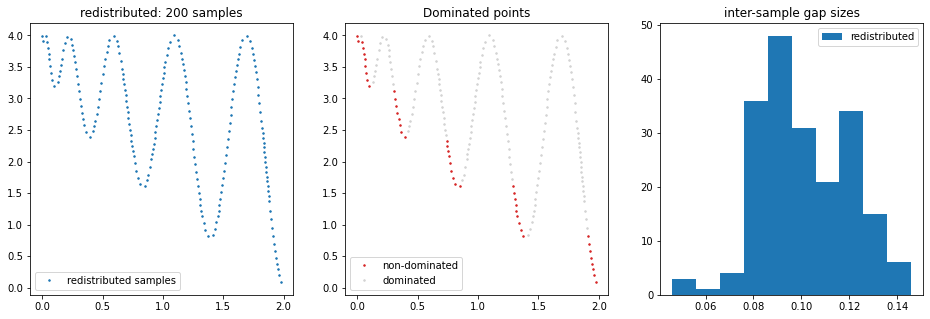

In [13]:
fig = plt.figure(figsize=[16, 5])
ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)
# ax0.axis('equal')
# ax1.axis('equal')

ax0.plot(*y_final.T, '.',  ms="3", label="redistributed samples")
ax0.legend()

ax1.plot(*y_final[pi_final].T, '.',  ms="3", c="C3", label="non-dominated")
ax1.plot(*y_final[di_final].T, '.',  ms="3", c="lightgrey", label="dominated")
ax1.legend()

# ax2.hist(gaps_orig, bins=bins, fc=(0.122, .467, .706, 0.3), label='original', density=True)
ax2.hist(gaps_final, fc=(0.122, .467, .706, 1.), label='redistributed')
ax2.legend()

ax0.set_title("redistributed: 200 samples")
ax1.set_title("Dominated points")
ax2.set_title("inter-sample gap sizes")

## 2D

In [14]:
## wfg problem
M = 3                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(M-1)
l = lfactor*2

func = wfg.WFG2

x_limits = np.array([[0]*(k+l),[i*2 for i in range(1, k+l+1)]])
x_limits

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  4,  6,  8, 10, 12, 14, 16]])

In [15]:
N = n_samples
f = np.zeros((N, M))
zs = np.zeros((N, k+l))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__, seed=0)
    zs[n,:] = z
    f[n,:] = func(z, k, M)

In [16]:
f.shape

(2000, 3)

In [17]:
for n in range(N):
#     z = wfg.random_soln(k, l, func.__name__, seed=0)
#     zs[n,:] = z
    f[n,:] = func(x_orig[n], k, M)

In [89]:
zs[0]

array([0.03260114, 0.97154708, 0.82338946, 6.43341403, 3.5       ,
       4.2       , 4.9       , 5.6       ])

In [90]:
x_orig.max(axis=0)

array([2. , 4. , 6. , 8. , 3.5, 4.2, 4.9, 5.6])

In [91]:
zs.min(axis=0)

array([4.46424820e-04, 2.08977051e-03, 2.81265937e-04, 6.43063337e-04,
       3.50000000e+00, 4.20000000e+00, 4.90000000e+00, 5.60000000e+00])

In [92]:
zs.max(axis=0)

array([1.99998714, 3.99764803, 5.99665154, 7.99600319, 3.5       ,
       4.2       , 4.9       , 5.6       ])

In [93]:
f

array([[8.54017711e-17, 8.54017711e-17, 6.00000000e+00],
       [1.90718493e-13, 1.23396471e-06, 5.99699868e+00],
       [3.05021393e-12, 4.93197649e-06, 5.99399848e+00],
       ...,
       [1.99371861e+00, 4.93197649e-06, 7.48331917e-03],
       [1.99685807e+00, 1.23396471e-06, 3.37178835e-03],
       [2.00000000e+00, 8.54017711e-17, 8.54017711e-17]])

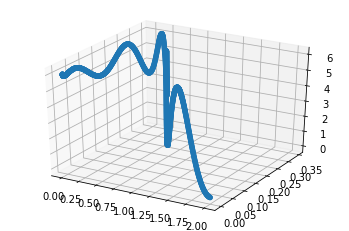

In [94]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(f[:,0], f[:,1], f[:,2])

In [33]:
## linearly space samples in parameter space
n_samples = 2000
samples0 = np.linspace(0, x_limits[1][0], n_samples)
samples1 = np.linspace(0, x_limits[1][1], n_samples)
samples2 = np.linspace(0, x_limits[1][2], n_samples)
samples3 = np.linspace(0, x_limits[1][3], n_samples)
x_orig = np.array([[sample0, sample1, sample2, sample3, 3.5, 4.2, 4.9, 5.6] for sample0, sample1, sample2, sample3 in zip(samples0, samples1, samples2, samples3)])

assert x_orig.shape == (n_samples, k+l)
x_orig.max(axis=0)

array([2. , 4. , 6. , 8. , 3.5, 4.2, 4.9, 5.6])

In [62]:
## get corresponding y values
y_orig = np.zeros((n_samples, M))
for i, xi in enumerate(x_orig):
    y_orig[i,:] = func(xi, k, M)
    
assert y_orig.shape == (n_samples, M)
y_orig.shape

(2000, 3)

In [74]:
y_orig.max(axis=0)

array([2.        , 0.34314557, 6.        ])

In [80]:
x_orig.max(axis=0)

array([2. , 4. , 6. , 8. , 3.5, 4.2, 4.9, 5.6])

In [78]:
zs.max(axis=0)

array([1.99998714, 3.99764803, 5.99665154, 7.99600319, 3.5       ,
       4.2       , 4.9       , 5.6       ])

In [75]:
f.max(axis=0)

array([1.52301294, 2.91491846, 5.99999994])

TypeError: multiple values for argument 's'

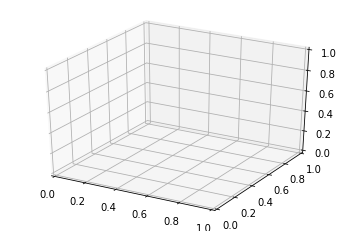

In [71]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(*y_orig.T)

In [35]:
## get indices for non-dominated elements of original samples
pi_orig = notDominated(y_orig) 
di_orig = np.invert(pi_orig)

In [36]:
## compute euclidean point distances
diffs_orig = y_orig[:-1] - y_orig[1:]
gaps_orig = np.array([np.sqrt(np.dot(d, d.T)) for d in diffs_orig])

np.testing.assert_array_equal(y_orig[np.argsort(y_orig[:,0])], y_orig)
gaps_orig.shape

(1999,)

Text(0.5, 1.0, 'inter-sample gap sizes')

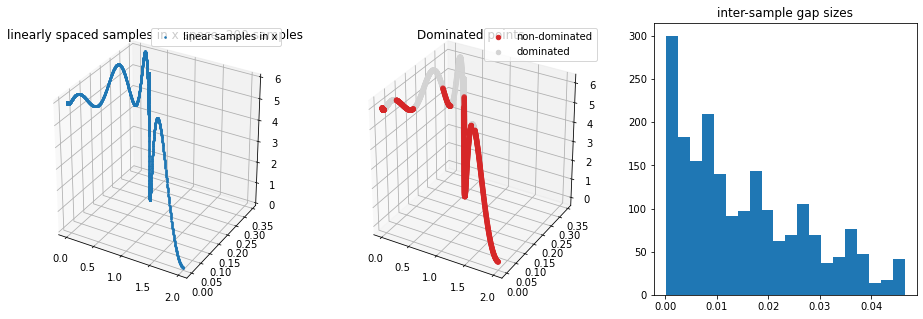

In [40]:
fig = plt.figure(figsize=[16, 5])
ax0 = fig.add_subplot(1,3,1, projection='3d')
ax1 = fig.add_subplot(1,3,2, projection='3d')
ax2 = fig.add_subplot(1,3,3)
ax0.plot(*y_orig.T, '.',  ms="3", label="linear samples in x")
ax0.legend()

ax1.scatter(*y_orig[pi_orig].T, c="C3", label="non-dominated")
ax1.scatter(*y_orig[di_orig].T, c="lightgrey", label="dominated")
ax1.legend()

flls, bins, _ = ax2.hist(gaps_orig, bins=20)

ax0.set_title("linearly spaced samples in x space: 200 samples")
ax1.set_title("Dominated points")
ax2.set_title("inter-sample gap sizes")

In [42]:
y_orig[pi_orig]

array([[8.54017711e-17, 8.54017711e-17, 6.00000000e+00],
       [1.90718493e-13, 1.23396471e-06, 5.99699868e+00],
       [3.05021393e-12, 4.93197649e-06, 5.99399848e+00],
       ...,
       [1.99371861e+00, 4.93197649e-06, 7.48331917e-03],
       [1.99685807e+00, 1.23396471e-06, 3.37178835e-03],
       [2.00000000e+00, 8.54017711e-17, 8.54017711e-17]])